In [1]:
import ebf
import healpix_util as hu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import healpy as hp
import astropy.stats as st
import astropy.visualization as av

In [2]:
def plotPixels(x, y, pixel_array, mapSky, pixelImages, plotEach=False, 
               xlim=(-2, 2.5), ylim=(2, -1), vmin=0.01, vmax=10., xlabel='log distance', ylabel='log proper motion', 
              fignameAll='pofd_allPixels.pdf', fignameEachpre='pofd'):
    fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axes = axes.flatten()
    if plotEach: fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
    #loop over pixel on sky
    for ax, pixel_index in zip(axes, range(np.max(pixel_array)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        if colorCut: index = (pixel_array == pixel_index)
        else: index = pixel_array == pixel_index
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                axis.hist2d(x[index], y[index], bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel(xlabel)
                axis.set_ylabel(ylabel)
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(pixelImages[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        fignow.savefig('{0}_{1:02d}.pdf'.format(fignameEachpre, pixel_index), rasterized=True)
    fig.savefig(fignameAll)
    plt.close(fig)
    plt.close(fignow)

In [3]:
datafile = '../GalaxiaData/sdssgalaxy_10percent.ebf'
#datafile = '../GalaxiaData/sdssHalo.ebf'
data = ebf.read(datafile, '/')

In [4]:
data.keys()

['rad',
 'exbv_solar',
 'teff',
 'sdss_g',
 'mag2',
 'mag1',
 'mag0',
 'sdss_r',
 'sdss_u',
 'satid',
 'vx',
 'vy',
 'vz',
 'sdss_z',
 'mtip',
 'log',
 'pz',
 'px',
 'py',
 'feh',
 'exbv_schlegel',
 'sdss_i',
 'lum',
 'exbv_schlegel_inf',
 'mact',
 'glon',
 'popid',
 'glat',
 'alpha',
 'center',
 'partid',
 'age',
 'grav',
 'smass',
 'fieldid']

In [5]:
c = coord.Galactic(u=data['px']*u.kpc, v=data['py']*u.kpc, w=data['pz']*u.kpc,
                 U=data['vx']*u.km/u.s, V=data['vy']*u.km/u.s, W=data['vz']*u.km/u.s,
                 representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)


In [6]:
appmag = data['sdss_g'] + 5.*np.log10(data['rad']*1000./10.)
redpm = appmag + 5.*np.log10(pm.value)

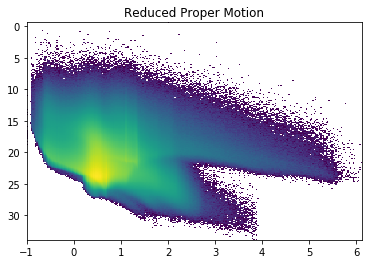

In [7]:
plt.hist2d(data['sdss_g'] - data['sdss_i'], redpm, bins=250, norm=mpl.colors.LogNorm())
plt.title('Reduced Proper Motion')
plt.gca().invert_yaxis()

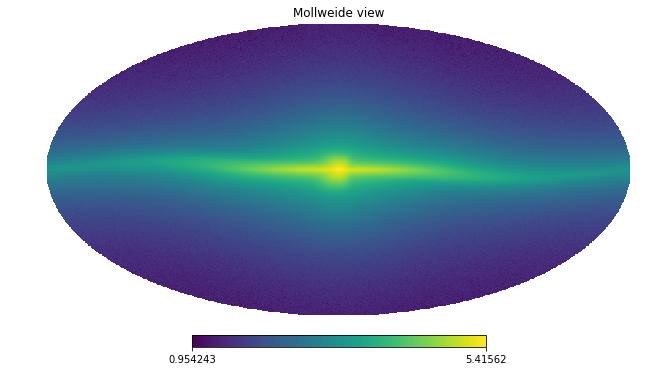

In [9]:
#for visualizing all data on the sky 
nside = 128
hpixMap = hu.HealPix("ring", nside)
pixnums = hpixMap.eq2pix(data['glon'], data['glat'])
omap = np.bincount(pixnums, minlength=hpixMap.npix)
mapSky = hp.mollview(np.log10(omap), return_projected_map=True)
plt.savefig('pofd_allsky.pdf')

In [10]:
#bin edges for proper motions 
bin_edges = np.array([0, 0.1, 1, 10, 100]) #np.logspace(-3, 3, 4)
#hist, bin_edges, patches = av.hist(pm, bins='blocks')
#print len(bin_edges)
pmInd = np.digitize(pm, bin_edges)
#plt.savefig('pmHistBayesBlocks.png')
nside = 2
hpix=hu.HealPix("ring", nside)
npix = hpix.npix
pixnums = hpix.eq2pix(data['glon'], data['glat'])

Text(0.5,1,u'sdss g apparent magnitude')

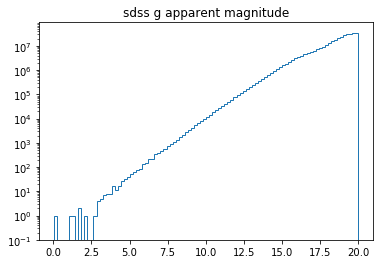

In [11]:
plt.hist(appmag, bins=100, histtype='step', log=True)
plt.title('sdss g apparent magnitude')

In [12]:
bin_edges = np.array([10, 15])
appmagInd = np.digitize(appmag, bin_edges)

In [13]:
xbin = 0.5*(bin_edges[1:] + bin_edges[:-1])
#plt.plot(xbin, hist, )

Text(0.5,1,u'Number of stars in each pixel')

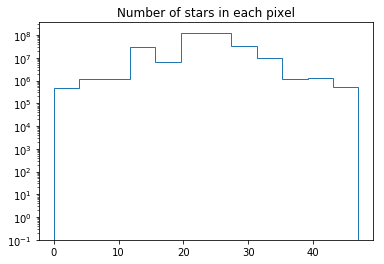

In [14]:
plt.clf()
plt.hist(pixnums, bins=12, log=True, histtype='step')
plt.title('Number of stars in each pixel')

KeyboardInterrupt: 

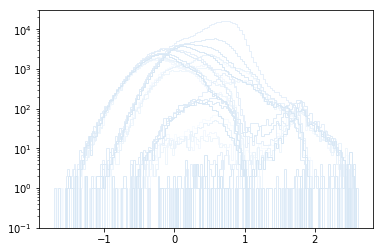

In [15]:
#color cooresponds to a given pixel
#the stars are binned up by pixel and proper motion
color=iter(plt.cm.Blues(np.linspace(0,1,48)))

for pix in range(np.max(pixnums)): 
    c=next(color)
    for pmi in range(np.max(pmInd)):

        plt.hist(np.log10(data['rad'][(pixnums == pix) & (pmInd == pmi)]), bins=100, log=True, histtype='step', color=c)
#plt.legend()
plt.xlim(-2, 2.5)
plt.ylim(1,)
plt.xlabel('log distance')
plt.ylabel('histogram')

In [ ]:
color=iter(plt.cm.Blues(np.linspace(0,1,48)))

for pix in range(np.max(pixnums)): 
        c=next(color)
        plt.hist(np.log10(data['rad'][(pixnums == pix)]), bins=100, log=True, histtype='step', color=c)
#plt.legend()
plt.xlim(-2, 2.5)
plt.ylim(1,)
plt.xlabel('log distance')
plt.ylabel('histogram')

  0: Thin Disk  < 0.15    Gyr
  1: Thin Disk     0.15-1 Gyr
  2: Thin Disk     1-2      Gyr 
  3: Thin Disk     2-3      Gyr
  4: Thin Disk     3-5      Gyr
  5: Thin Disk     5-7      Gyr
  6: Thin Disk     7-10    Gyr
  7: Thick Disk 
  8: Stellar Halo
  9: Bulge

In [ ]:
thinDisk  = data['popid'] < 7
thickDisk = data['popid'] == 7
halo      = data['popid'] == 8
bulge     = data['popid'] == 9
BJhalo    = data['popid'] == 10

In [ ]:
indices = [thinDisk, thickDisk, halo]

In [ ]:
fig, axes = plt.subplots(4*nside, 3*nside, figsize=(8*nside, 8*nside))
axes = axes.flatten()
npix = hpix.npix # hp.nside2npix(nside)
pixelImages = []
for i in range(npix):
    mask = np.zeros(npix)
    mask[i] = 1.0
    map = hp.mollview(mask, return_projected_map=True)
    axes[i].imshow(map, origin='lower')
    pixelImages.append(map)
fig.savefig('pofd_sky.pdf')
plt.close(fig)

In [ ]:
plotPixels(np.log10(data['rad'][colorCut]), np.log10(pm[colorCut].value), pixnums, mapsky, pixelImages, plotEach=True)



fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
   
axes = axes.flatten()
xlim = (-2, 2.5)
ylim = (2, -1)
vmin = 0.01
vmax = 10.0
#loop over pixel on sky
for ax, pixel_index in zip(axes, range(np.max(pixnums)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
        index = (pixnums == pixel_index) & colorCut
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                axis.hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel('log distance')
                axis.set_ylabel('log proper motion')
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(pixelImage[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        fignow.savefig('pofd_{0:02d}.pdf'.format(pixel_index), rasterized=True)
fig.savefig('pofd_allPixels.pdf')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
axes[nside*3-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.close(fig)
plt.close(fignow)

In [ ]:
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
labels = ['thickDisk', 'thinDisk', 'halo']

#loop over population type
for ind, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, pixelImages, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))



plotIndPop = True
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
labels = ['thickDisk', 'thinDisk', 'halo']
xlim = (-2, 2.5)
ylim = (2, -1)
vmin = 0.01
vmax = 10.0
plotIndPop = True
figNow, axesnow = plt.subplots(1, 2, figsize=(10, 5))

#loop over population type
for ind, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))

    figAllPix, axAllPix = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axAllPix = axAllPix.flatten()

    #loop over pixel on sky
    for pixel_index in range(np.max(pixnums)+1):
        axesnow[0].cla()
        axesnow[1].cla()
        index = (pixnums == pixel_index) & colorCut & ind
        axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
        axesnow[1].imshow(pixelImage[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
        for ax in [axAllPix[pixel_index], axesnow[0]]:
            ax.hist2d(np.log10(data['rad'][index]), np.log10(pm[index].value), bins=100, normed=True, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel('log distance')
            ax.set_ylabel('log proper motion')
        axesnow[1].set_xlabel('l')
        axesnow[1].set_ylabel('b')
        figNow.savefig('pofd_{0:02d}_{1}.pdf'.format(pixel_index, l), rasterized=True)
    figAllPix.savefig('pofd_allPixels_{0}.pdf'.format(l), rasterized=True)
    plt.close(figAllPix)
plt.close(figNow)

In [ ]:
#pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)
for quant in [c.pm_b, c.pm_l_cosb]
labels = ['mub', ]
colorCut = (data['sdss_g'] - data['sdss_i']>0.5) & (data['sdss_g'] - data['sdss_i']<0.75)
plotPixels(np.log10(data['rad']), np.log10(pm.value), pixnums, colorCut=colorCut)


for quant, l in zip(indices, labels):
    pixnumsMap = hpixMap.eq2pix(data['glon'][ind & colorCut], data['glat'][ind & colorCut])
    omap = np.bincount(pixnumsMap, minlength=hpix.npix)
    mapSky = hp.mollview(np.log10(omap), return_projected_map=True)

    plotPixels(np.log10(data['rad'][colorCut&ind]), np.log10(pm[colorCut&ind].value), pixnums, mapsky, pixelImages, plotEach=True, 
               fignameAll='pofd_allPixels_{0}.pdf'.format(l), fignameEachpre='pofd_{0}'.format(l))



In [ ]:

    image = np.zeros((len(xbins)-1, len(ybins)-1, 4))
    lattice = np.ones((len(xbins)-1, len(ybins)-1))
    index = magInd & pixInd & colorInd
             hist, xedge, yedge = np.histogram2d(np.log10(data['rad'][index]), np.log10(pm[index].value),  
                                                    bins=[xbins,ybins])#, normed=True)
            image[:,:,i] = hist 
            testImage = np.zeros((len(xbins)-1, len(ybins)-1, 4))
            testLattice = np.zeros((len(xbins)-1, len(ybins)-1))
            badPixel = hist < vmin
            ax.pcolormesh(x, y, z, cmap=cm, norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
            #plt.hist(hist, bins=100, log=True)
            testLattice[badPixel] = vmin
            testImage[:,:,i] = hist
            testImage[:,:,3] = testLattice
            popaxes[i][axI].imshow(testImage, origin='lower', extent=(-2, 2.5, -2, 2.5), norm=mpl.colors.LogNorm(vmin=vmin, vmax=1))
    badPixel = np.sum(image[:,:,0:3], axis=2) < vmin
    #print np.sum(badPixe
    lattice[badPixel] = vmin
    image[:,:,3] = lattice


In [ ]:
map = hp.mollview(mask, return_projected_map=True)
np.shape(map)

In [ ]:
m = np.arange(hp.nside2npix(nside))
hp.mollview(m, nest=False, title="Mollview image Nest")

In [ ]:
print m
print hp.nside2npix(nside)